In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import langevin
from scipy.stats import pearsonr
from scipy.optimize import minimize_scalar
import theano.tensor as tt


SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 35010732 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep', 'arviz-colors', 'arviz-white', 'arviz-whitegrid', 'arviz-darkgrid']


In [3]:
# function to calculate A and B from the dataset
def OUanalytic1(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/2/A**2
    Btmp = (N-1)*(1+B**2)/(1-B**2)**2
    tmp = (2+6*B**2)*(data1sq+dataNsq) + (4+12*B**2)*datasq - (12*B+4*B**3)*datacorr
    P2B = Btmp - tmp/A/2/(1-B**2)**3
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult1(data,deltat):
    A, dA, B ,dB = OUanalytic1(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [4]:
# function to calculate A and B from the dataset
def OUanalytic2(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/A**2/2
    Btmp = B**2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B**4*(N-1))*datasq - 2*B*(1+B**2+2*N)*datacorr
    P2B = -tmp/((1-B**2)**2*(data1sq+dataNsq + (1+B**2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult2(data,deltat):
    A, dA, B ,dB = OUanalytic2(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [5]:
class Ornstein_Uhlenbeck(pm.Continuous):
    """
    Ornstein-Uhlenbeck Process
    Parameters
    ----------
    B : tensor
        B > 0, B = exp(-(D/A)*delta_t)
    A : tensor
        A > 0, amplitude of fluctuation <x**2>=A
    delta_t: scalar
        delta_t > 0, time step
    """

    def __init__(self, A=None, B=None,
                 *args, **kwargs):
        super(Ornstein_Uhlenbeck, self).__init__(*args, **kwargs)
        self.A = A
        self.B = B
        self.mean = 0.

    def logp(self, x):
        A = self.A
        B = self.B

        x_im1 = x[:-1]
        x_i = x[1:]

        ou_like = pm.Normal.dist(mu=x_im1*B, tau=1.0/A/(1-B**2)).logp(x_i)
        return pm.Normal.dist(mu=0.0,tau=1.0/A).logp(x[0]) + tt.sum(ou_like)


In [6]:
A,D = 1.0,1.0
sN = 0.5
delta_t = 0.01
#M=1000 # number of data sets
N=2000 # length of data set
#print(np.exp(-delta_t*D/A))

In [7]:
data = langevin.time_series(A=A, D=D, delta_t=delta_t, N=N)
dataN = data + np.random.normal(loc=0.0, scale=sN, size=N)

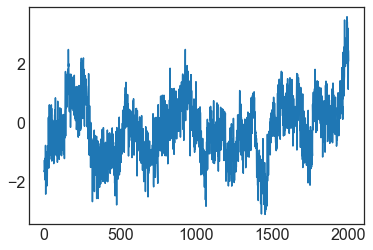

In [8]:
plt.plot(dataN)

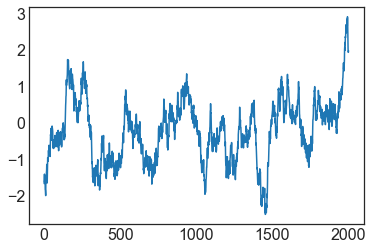

In [9]:
plt.plot(data)

In [10]:
%%timeit
a_bound=20
# compile model for reuse
with pm.Model() as model:
    B = pm.Beta('B', alpha=5.0,beta=1.0)
    A = pm.Uniform('A', lower=0, upper=a_bound)

    path = Ornstein_Uhlenbeck('path',A=A, B=B, observed=data)
    
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, B]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:14<00:00, 672.67draws/s]
The acceptance probability does not match the target. It is 0.8920219146634304, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6616371328262058, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9585484450892338, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, B]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:12<00:00, 803.96draws/s]
The acceptance probabil

15.8 s ± 647 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
pm.summary(trace)

NameError: name 'trace' is not defined

In [ ]:
pm.traceplot(trace)

In [12]:
%%timeit
a_bound=20
# compile model for reuse
with pm.Model() as model:
    B = pm.Beta('B', alpha=5.0,beta=1.0)
    A = pm.Uniform('A', lower=0, upper=a_bound)
    sigma = pm.Uniform('sigma',lower=0,upper=5)

    path = Ornstein_Uhlenbeck('path',A=A, B=B,shape=len(dataN))
    dataObs = pm.Normal('dataObs',mu=path,sigma=sigma,observed=dataN)
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [02:47<00:00, 59.60draws/s]
The acceptance probability does not match the target. It is 0.8836078942043889, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8977236700046956, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [02:42<00:00, 61.62draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Mu

2min 53s ± 19.4 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
pm.summary(trace)

In [ ]:
pm.traceplot(trace)

In [ ]:
avgpath = np.mean(trace['path'],axis=0)
stdpath = np.std(trace['path'],axis=0)
print(avgpath.shape)

In [ ]:
plt.plot(data-avgpath)
print(np.std(data-avgpath))

In [ ]:
plt.plot(dataN-data)
print(np.std(dataN-data))

In [ ]:
plt.plot(stdpath)
print(stdpath.mean())

In [ ]:
AA,DD = 1.0,1.0
sN = 0.5
total_noise = np.sqrt(AA+sN**2)
print("total noise: ",total_noise)
delta_t_list=np.linspace(0.01,4,50)
#M=1000 # number of data sets
N=2000 # length of data set
#print(np.exp(-delta_t*D/A))

In [ ]:
result_array = None
for delta_t in delta_t_list:
    print(delta_t)
    data = langevin.time_series(A=AA, D=DD, delta_t=delta_t, N=N)
    dataN = data + np.random.normal(loc=0.0, scale=sN, size=N)
    with pm.Model() as model:
        B = pm.Beta('B', alpha=5.0,beta=1.0)
        A = pm.Uniform('A', lower=0, upper=a_bound)
        sigma = pm.Uniform('sigma',lower=0,upper=5)

        path = Ornstein_Uhlenbeck('path',A=A, B=B,shape=len(dataN))
        dataObs = pm.Normal('dataObs',mu=path,sigma=sigma,observed=dataN)
        trace = pm.sample(2000)
        
    a_mean = trace['A'].mean()
    b_mean = trace['B'].mean()
    a_std = trace['A'].std()
    b_std = trace['B'].std()
    sigma_mean = trace['sigma'].mean()
    sigma_std = trace['sigma'].std()
    avgpath = np.mean(trace['path'],axis=0)
    stddiff = np.std(data-avgpath)
    stdpath = np.std(trace['path'],axis=0).mean()
    
    results = [a_mean,a_std,b_mean,b_std,sigma_mean,sigma_std,stddiff,stdpath]
    if result_array is None:
        result_array = results
    else:
        result_array = np.vstack((result_array, results))

In [ ]:
tau = -delta_t_list/np.log(result_array.T[2])
dtau = delta_t_list*result_array.T[3]/result_array.T[2]/np.log(result_array.T[2])**2


In [ ]:
plt.plot(delta_t_list,result_array.T[6],"o")
plt.xlabel(r'$\Delta t/\tau$')
plt.ylabel(r'$\sigma_{GT-model}$')

In [ ]:
plt.errorbar(delta_t_list,result_array.T[0],yerr=result_array.T[1],fmt="o",label="A")
plt.errorbar(delta_t_list,tau,dtau,fmt="o",label=r'$\tau$')
plt.legend(loc="upper left")

In [ ]:
plt.errorbar(delta_t_list,result_array.T[4],yerr=result_array.T[5],fmt="o")
plt.xlabel(r'$\Delta t/\tau$')
plt.ylabel(r'$\sigma_{noise}$')